# Tiền xử lí

In [3]:
import cv2
import os

In [4]:
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

In [5]:
def extract_faces_from_image(image_path, output_path, face_count):
    print(f"Processing image: {image_path}")
    img = cv2.imread(image_path)
    faces = face_cascade.detectMultiScale(img, scaleFactor=1.3, minNeighbors=5)
    for (x, y, w, h) in faces:
        face = cv2.resize(img[y+1:y+h-1, x+1:x+w-1], (128, 128))
        face_count += 1
        cv2.imwrite(f'{output_path}/face_{face_count}.jpg', face)
    return face_count

In [6]:
def extract_faces_from_video(video_path, output_path, face_count):
    print(f"Processing video: {video_path}")
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print(f"Can't open {video_path}")
        return face_count

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        faces = face_cascade.detectMultiScale(frame, scaleFactor=1.3, minNeighbors=5)
        for (x, y, w, h) in faces:
            roi = cv2.resize(frame[y+1:y+h-1, x+1:x+w-1], (128, 128))
            face_count += 1
            cv2.imwrite(f'{output_path}/face_{face_count}.jpg', roi)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()
    return face_count

In [7]:
def process_data_directory(data_path):
    for category in os.listdir(data_path):
        if category != '.DS_Store':
            category_path = os.path.join(data_path, category)
            face_count = 0
            output_path = category_path.replace('dataRaw', 'dataset')
            
            os.makedirs(output_path, exist_ok=True)

            for data_item in os.listdir(category_path):
                if data_item != '.DS_Store':
                    item_path = os.path.join(category_path, data_item)

                    if item_path.endswith('.mp4'):
                        face_count = extract_faces_from_video(item_path, output_path, face_count)

                    if item_path.endswith(('.jpg', '.png', '.jpeg')):
                        face_count = extract_faces_from_image(item_path, output_path, face_count)

            print(f"Total faces in {category}: {face_count}")

In [8]:
# Process training and testing data directories
data_train_path = 'dataRaw/train_data'
data_test_path = 'dataRaw/test_data'

process_data_directory(data_train_path)
process_data_directory(data_test_path)

Processing video: dataRaw/train_data\David Beckham\davidbekham.mp4
Total faces in David Beckham: 878
Processing video: dataRaw/train_data\G-Dragon\GD.mp4
Total faces in G-Dragon: 1743
Processing video: dataRaw/train_data\Justin Bieber\justinbieber.mp4
Total faces in Justin Bieber: 1694
Processing video: dataRaw/train_data\Messi\messi.mp4
Total faces in Messi: 1638
Processing image: dataRaw/train_data\Reus\image.jpg
Processing video: dataRaw/train_data\Reus\reus.mp4
Total faces in Reus: 913
Processing video: dataRaw/train_data\Ronaldo\ronaldo.mp4
Total faces in Ronaldo: 2233
Processing video: dataRaw/train_data\Son Tung\sontung.mp4
Total faces in Son Tung: 1298
Processing image: dataRaw/test_data\David Beckham\a1f88b4a3c5c5b6761438553fe38ab872d9f59cc.jpg
Processing image: dataRaw/test_data\David Beckham\amh.jpg
Processing image: dataRaw/test_data\David Beckham\Becks.jpg
Processing image: dataRaw/test_data\David Beckham\david beckham makeup tutorial.jpg
Processing image: dataRaw/test_dat

# Huấn luyện mô hình

In [5]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from PIL import Image

In [22]:
from tensorflow.python.client import device_lib
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]
print(get_available_devices()) 
# my output was => ['/device:CPU:0']
# good output must be => ['/device:CPU:0', '/device:GPU:0']

['/device:CPU:0']


In [7]:
print("Number of GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
# In thông tin chi tiết về GPU (nếu có)
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    for device in physical_devices:
        print("GPU Device Name:", device.name)
else:
    print("Không tìm thấy GPU.")

# In thông tin chi tiết về GPU sử dụng TensorFlow
print("GPU Device Name used by TensorFlow:", tf.test.gpu_device_name())
print(tf.random.normal([10,10]))

Number of GPUs Available:  0
2.10.0
Không tìm thấy GPU.
GPU Device Name used by TensorFlow: 


In [8]:
TRAIN_DATA = 'dataset/train_data'
TEST_DATA = 'dataset/test_data'
print(tf.__version__)

In [9]:
classes = []

# Lists to store data for training and testing
xtrain = []
ytrain = []
xtest = []
ytest = []

# Dictionary to map class names to labels
dictionary = {}
np.random.seed(5)

In [10]:
#Get Dictionary from Data
class Dictionary:
    def __init__(self, path):
        self.path = path
        self.dictionary = {}
    def operate(self):
        number = 0
        for name in os.listdir(self.path):
            if not name.startswith('.'):
                self.dictionary[name] = number
                number += 1
        return self.dictionary

In [11]:
# Example debugging in the Data class
class Data:
    def __init__(self, path, dictionary):
        self.path = path
        self.dictionary = dictionary
        self.input = []
        self.label = []
        self.listData = []

    def getData(self):
        for whatever in os.listdir(self.path):
            if whatever != '.DS_Store':
                label = whatever
                whatever_path = os.path.join(self.path, whatever)
                list_data_filename_path = []
                
                for filename in os.listdir(whatever_path):
                    if filename != '.DS_Store':
                        filename_path = os.path.join(whatever_path, filename)
                        if filename_path.endswith(('.jpg', '.png', '.jpeg')):
                            img = np.array(Image.open(filename_path))
                            list_data_filename_path.append((img, self.dictionary[label]))

                self.listData.extend(list_data_filename_path)
        return self.listData

    def operate(self):
        self.listData = self.getData()
        np.random.shuffle(self.listData)
        for Data in self.listData:
            self.input.append(np.array(Data[0])) 
            self.label.append(Data[1])
        return self.input, self.label

In [12]:
dictionary = Dictionary(TRAIN_DATA).operate()
classes = list(dictionary.keys())
print(dictionary)

{'David Beckham': 0, 'G-Dragon': 1, 'Justin Bieber': 2, 'Messi': 3, 'Reus': 4, 'Ronaldo': 5, 'Son Tung': 6}


In [13]:
print(os.listdir('dataset/train_data'))

['David Beckham', 'G-Dragon', 'Justin Bieber', 'Messi', 'Reus', 'Ronaldo', 'Son Tung']


In [14]:
# Example usage with debugging
xtrain, list_train = Data(TRAIN_DATA, dictionary).operate()
xtest, list_test = Data(TEST_DATA, dictionary).operate()

NameError: name 'Data' is not defined

In [15]:
print(len(xtrain))
print(len(xtest))

NameError: name 'xtrain' is not defined

In [16]:
# Normalize data to the range [0, 1]
xtrain, xtest = np.array(xtrain) / 100, np.array(xtest) / 100

# Expand dimensions for the channel (3 for RGB)
ytrain, ytest = np.array([np.expand_dims(item, axis=0) for item in list_train]), np.array([np.expand_dims(item, axis=0) for item in list_test])

# Convert labels to one-hot encoding
ytrain_ohe, ytest_ohe = to_categorical(ytrain), to_categorical(ytest)

: 

In [17]:
def build_cnn_model(input_shape=(128,128,3)):
    model = models.Sequential([
        layers.Conv2D(32,(3,3), input_shape=(128,128,3),activation='relu'),
        layers.MaxPool2D((2,2)),
        layers.Dropout(0.15),

        layers.Conv2D(64,(3,3),activation='relu'),
        layers.MaxPool2D((2,2)),
        layers.Dropout(0.2),

        layers.Conv2D(128,(3,3),activation='relu'),
        layers.MaxPool2D((2,2)),
        layers.Dropout(0.2),

        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(256, activation='relu'),
        layers.Dense(len(classes), activation='softmax')
    ])
    return model

In [18]:
siamese_model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
history = siamese_model.fit(xtrain,ytrain_ohe,epochs=10,validation_data=(xtest,ytest_ohe))

Epoch 1/10
325/325 [==============================] - 257s 780ms/step - loss: 0.3949 - accuracy: 0.8831 - val_loss: 3.7744 - val_accuracy: 0.4286
Epoch 2/10
325/325 [==============================] - 276s 850ms/step - loss: 0.0428 - accuracy: 0.9886 - val_loss: 2.6380 - val_accuracy: 0.4107
Epoch 3/10
325/325 [==============================] - 286s 881ms/step - loss: 0.0233 - accuracy: 0.9944 - val_loss: 2.1467 - val_accuracy: 0.5357
Epoch 4/10
325/325 [==============================] - 276s 849ms/step - loss: 0.0078 - accuracy: 0.9978 - val_loss: 2.6170 - val_accuracy: 0.6250
Epoch 5/10
325/325 [==============================] - 284s 874ms/step - loss: 0.0047 - accuracy: 0.9987 - val_loss: 3.3510 - val_accuracy: 0.5179
Epoch 6/10
325/325 [==============================] - 260s 800ms/step - loss: 0.0013 - accuracy: 0.9997 - val_loss: 3.1394 - val_accuracy: 0.6071
Epoch 7/10
325/325 [==============================] - 271s 834ms/step - loss: 0.0298 - accuracy: 0.9912 - val_loss: 3.2989 -

2/2 - 0s - loss: 3.5700 - accuracy: 0.5536 - 291ms/epoch - 146ms/step


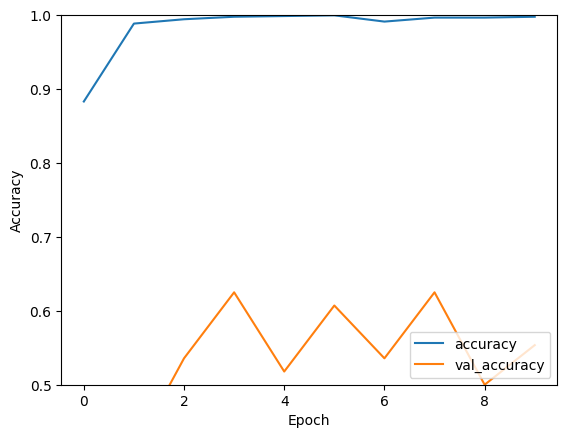

In [19]:
#Vẽ biểu đồ của accuracy và val_accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
test_loss, test_acc = siamese_model.evaluate(xtest, ytest_ohe, verbose=2)
plt.show()

# Test

In [20]:
xtrain, list_train = Data(TRAIN_DATA, dictionary).operate()
xtest, list_test = Data(TEST_DATA, dictionary).operate()
xtrain, xtest = np.array(xtrain)/100, np.array(xtest)/100
ytrain, ytest = np.array([np.expand_dims(item, axis=0) for item in list_train]), np.array([np.expand_dims(item, axis=0) for item in list_test])
classes = list(dictionary.keys())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 423ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 46ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 40ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 40ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 38ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 38ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 36ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 37ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 40ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 40ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 41ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 41ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 42ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 41ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 44ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 45ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 49ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 74ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 69ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 63ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 62ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 62ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 54ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 53ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 50ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 49ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 49ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 50ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 45ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 42ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 44ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 42ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 38ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 36ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 36ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 41ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 40ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 53ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 57ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 48ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 50ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 43ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 46ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 44ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 44ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 43ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 42ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 42ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 48ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 41ms/step
50


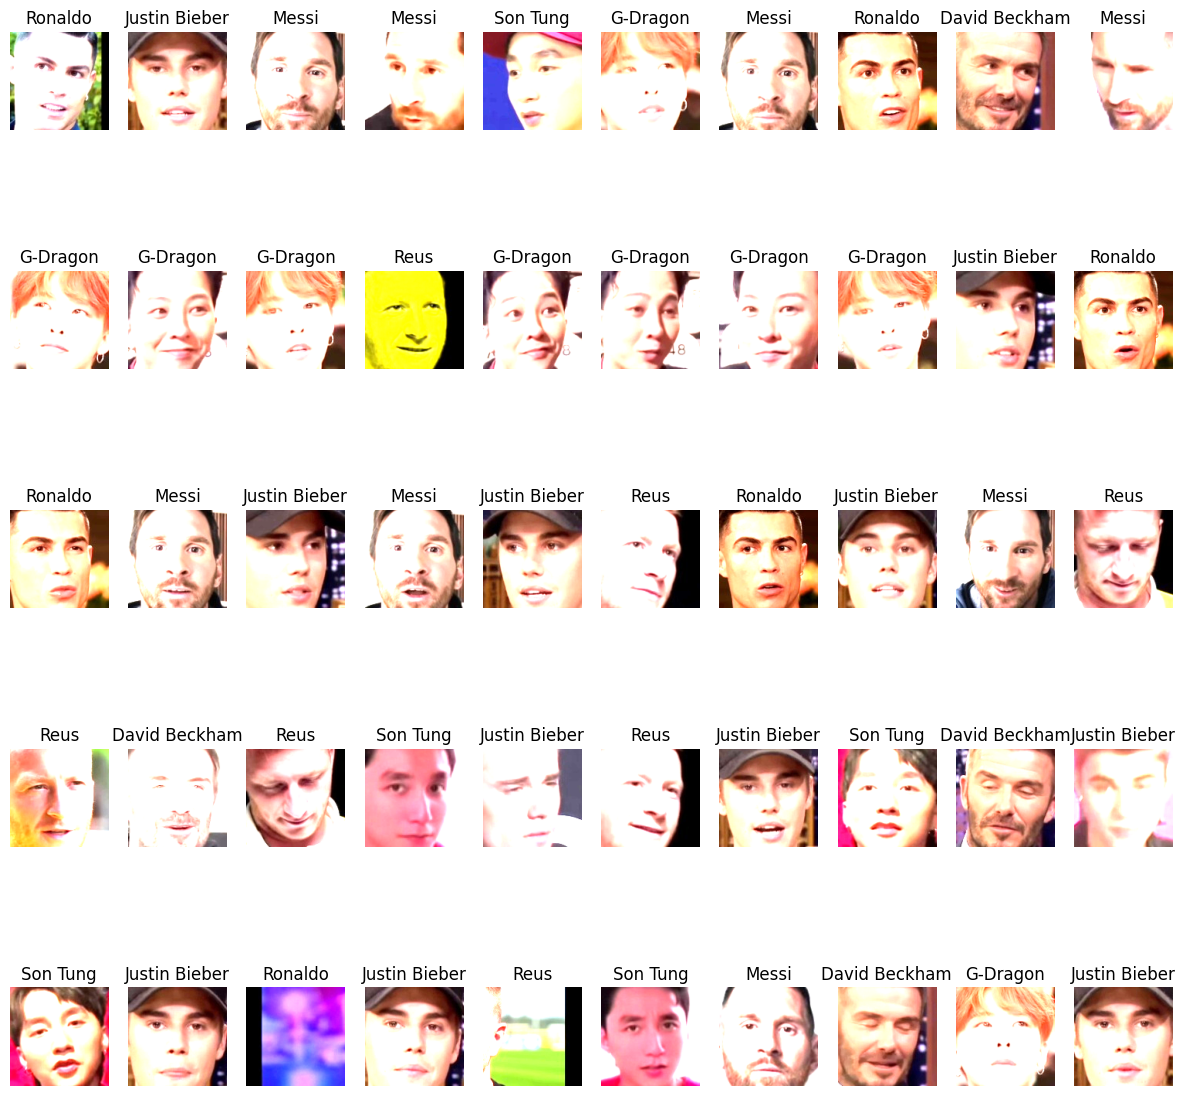

In [21]:
acc = 0
fig = plt.figure(figsize=(15,15))
for i in range(50):
    plt.subplot(5,10,i+1)
    #Vì dataset/train chưa đủ lớn, đa dạng nên để xtest thì tỷ lệ đúng ít, thử thay xtest, ytest thành xtrain, ytrain (tỉ lệ đúng khá cao)
    plt.imshow(xtrain[i])
    result = np.argmax(siamese_model.predict(xtrain[i].reshape((-1,128,128,3))))
    if result == ytrain[i][0]:
        acc +=1
    plt.title(classes[result])
    plt.grid(color='lightgray', linestyle='--')
    plt.axis("off")

print(acc)
plt.show()